In [1]:
import tensorflow as tf
import numpy as np
import h5py
# import pydicom as dicom
import scipy.misc
import time
import os
from sklearn.utils import shuffle
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\edwar\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
os.environ['CUDA_VISIBLE_DEVICES']= '0'

In [3]:
# Generator
def CPCE(inputs, padding='valid'):
    #inputs = tf.placeholder(dtype=tf.float32, shape=[None, input_width, input_height, 1])
    outputs1 = tf.layers.conv2d(inputs, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv1', use_bias=False)
    outputs2 = tf.nn.relu(outputs1)
    
    outputs2 = tf.layers.conv2d(outputs2, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv2', use_bias=False)
    outputs3 = tf.nn.relu(outputs2)
    
    outputs3 = tf.layers.conv2d(outputs3, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv3', use_bias=False)
    outputs4 = tf.nn.relu(outputs3)
    
    outputs4 = tf.layers.conv2d(outputs4, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv4', use_bias=False)
    outputs5 = tf.nn.relu(outputs4)
    
    outputs5 = tf.layers.conv2d_transpose(outputs5, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='deconv5', use_bias=False)
    outputs5 = tf.concat([outputs3, outputs5], 3)
    outputs5 = tf.nn.relu(outputs5)
    
    outputs5 = tf.layers.conv2d(outputs5, 32, 1, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='transpose1', use_bias=False)
    outputs6 = tf.nn.relu(outputs5)

    outputs6 = tf.layers.conv2d_transpose(outputs6, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='deconv6', use_bias=False)
    outputs6 = tf.concat([outputs2, outputs6], 3)
    outputs6 = tf.nn.relu(outputs6)
    
    outputs6 = tf.layers.conv2d(outputs6, 32, 1, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='transpose2', use_bias=False)
    outputs7 = tf.nn.relu(outputs6)

    outputs7 = tf.layers.conv2d_transpose(outputs7, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='deconv7', use_bias=False)
    outputs7 = tf.concat([outputs1, outputs7], 3)
    outputs7 = tf.nn.relu(outputs7)
    
    outputs7= tf.layers.conv2d(outputs7, 32, 1, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='transpose3', use_bias=False)
    outputs8 = tf.nn.relu(outputs7)

    outputs8 = tf.layers.conv2d_transpose(outputs8, 1, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='deconv8', use_bias=False)
#     outputs = tf.nn.relu(outputs8 + inputs)
    outputs = outputs8 + inputs
    
    return outputs

In [4]:
def read_matDat(filepath, dataFileNamePattern, dataNamePattern, labelFileNamePattern, labelNamePattern, fileNum):
    dataFileName = filepath+'/'+dataFileNamePattern+str(fileNum[0])
    mat_contents = sio.loadmat(dataFileName)
    data = mat_contents[dataNamePattern]
    
    labelFileName = filepath+'/'+labelFileNamePattern+str(fileNum[0])
    mat_contents = sio.loadmat(labelFileName)
    label = mat_contents[labelNamePattern]
    
    for ntag in fileNum[1:-1]:
        dataFileName = filepath+'/'+dataFileNamePattern+str(ntag)
        mat_contents = sio.loadmat(dataFileName)
        data = np.concatenate((mat_contents[dataNamePattern], data), axis=2)
        
        labelFileName = filepath+'/'+labelFileNamePattern+str(ntag)
        mat_contents = sio.loadmat(labelFileName)
        label = np.concatenate((mat_contents[labelNamePattern], data), axis=2)
    # move slice dimension to the fist axis    
    data = np.moveaxis(data, 2, 0)
    label = np.moveaxis(label, 2, 0) 
    data = np.expand_dims(data, axis=3)
    label = np.expand_dims(label, axis=3)
    return data, label

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession().close()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# input size
X = tf.placeholder(dtype=tf.float32, shape=[None, 512, 512, 1])
with tf.variable_scope('generator_model') as scope:
    out = CPCE(X, padding='valid') 
    
# ground truth
Y = tf.placeholder(dtype=tf.float32, shape=[None, 512, 512, 1])
mse_cost = tf.reduce_mean(tf.squared_difference(out, Y)) 


#########
newdatflg = 1
#########

if newdatflg:
    filepath = './new_dat/'
    X_batch, Y_batch = read_matDat(filepath,'STEDout','STEDimgs','GTout','GTimgs', np.arange(12,13,1))
else:
    filepath = './old_dat/'
    X_batch, Y_batch = read_matDat(filepath,'STEDimgs_','STEDimgs','GTimgs_','GTimgs', np.arange(12,13,1))
    
X_batch = X_batch[0:9].astype('float32')/256.0
Y_batch = Y_batch[0:9].astype('float32')/256.0

with tf.Session(config=config) as sess:
    saver = tf.train.Saver()
    sess_path ='trained_results/CPCE_SR-13.ckpt'
    saver.restore(sess, sess_path)
    _out,_mse_cost = sess.run([out,mse_cost], feed_dict={X:X_batch, Y:Y_batch})
    
sess.close  
print('mse_cost is %.8f' % _mse_cost)

_out = np.squeeze(_out)
X_batch = np.squeeze(X_batch)
Y_batch = np.squeeze(Y_batch)

aErr = _out - Y_batch 
rErr = (_out - Y_batch)/(Y_batch+0.001)*100
I_in =  X_batch 

if newdatflg:
    sio.savemat('./new_dat/testResult.mat', {'OUT':_out,'IN':X_batch,'GT':Y_batch})
else:
    sio.savemat('./old_dat/testResult.mat', {'OUT':_out,'IN':X_batch,'GT':Y_batch})    


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from trained_results/CPCE_SR-13.ckpt
mse_cost is 0.00018901


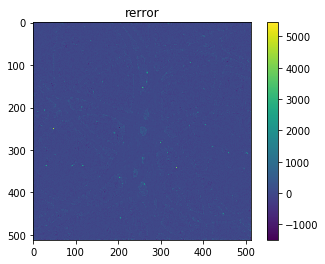

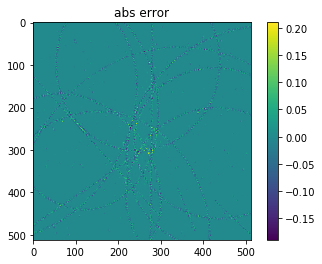

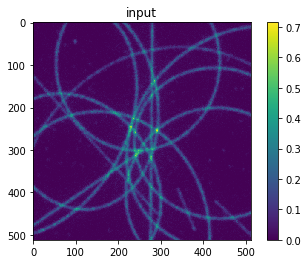

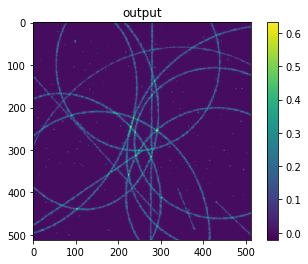

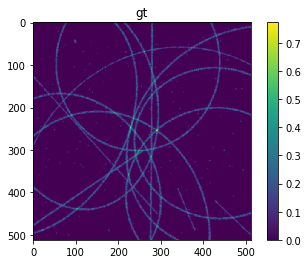

In [7]:
tstnum = 7

plt.figure
plt.imshow(rErr[tstnum,:,:])
plt.title('rerror')
plt.colorbar()
plt.show()

plt.figure
plt.imshow(aErr[tstnum,:,:])
plt.title('abs error')
plt.colorbar()
plt.show()

plt.figure
plt.imshow(X_batch[tstnum,:,:])
plt.title('input')
plt.colorbar()
plt.show()

plt.figure
plt.imshow(_out[tstnum,:,:])
plt.title('output')
plt.colorbar()
plt.show()

plt.figure
plt.imshow(Y_batch[tstnum,:,:])
plt.title('gt')
plt.colorbar()
plt.show()